# Wavelength Calibration

In this notebook, I find different wavelength ranges over which we will generate light curves.

**NOTE:** Data after 5/9/2018 is calibrated to different wavelengths than the true wavelength. The header of these files also contains an extra line specifying the exposure time. Keep this in mind when reading the data in.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pan
from glob import glob
%matplotlib inline

In [4]:
# Extracts times, wavelengths, and fluxes from raw data files
def get_data(filename):
    # Open the file and save the first two lines
    f = open(filename,'r')
    line1 = f.readline() # Date and start time of observations in UTC
    line2 = f.readline() # Exposure time used for observations
    f.close()
    # Reads in wavelengths for each column listed in the third line of the file
    wlen = np.genfromtxt(filename,delimiter=',',skip_header=2,max_rows=1)[1:]
    
    # Pull start time (UTC) from first line & save as float
    hour = float(line1[21:23])
    minute = float(line1[24:26])
    second = float(line1[27:])
    start_time = hour + minute/60 + second/3600
    
    # Reads the time and flux data
    dat = np.genfromtxt(filename,skip_header=3,skip_footer=1,delimiter=',')
    
    # Saves time and flux data as separate arrays
    time = dat[:,0]/3600+start_time
    allflux = dat[:,1:]
    return wlen,allflux,time[1:]

## Setting wavelength ranges

Before you start generating light curves, you need to have an idea of the wavelength ranges with which the light curve will be generated. In order to do this, plot one of the spectrum from your Venus data and look for the Ca II H&K lines. Once you have found a general wavelength range, it is a good idea to plot different spectra to double check the selected wavelength range.

Below, two different ranges have been found for both absorption lines. One is very narrowly centered on the line, while the other is a bit wider.

**NOTE:** Subtracting the dark spectrum will make finding these absorption lines much easier as they can be lost in the noise.

In [5]:
# Reads in dark spectra
dark_wlen,darkflux,darktime = get_data('../venus_data/20180605/dark7s_1.dat')
# Averages dark spectra
avdflux = np.mean(darkflux[1:],axis=0)

# Reads in Venus spectra
wlen,allflux,time = get_data('../venus_data/20180606/venus_1.dat')
# Subtracts dark spectra noise from Venus spectra
rflux = [np.subtract(i,avdflux) for i in allflux]

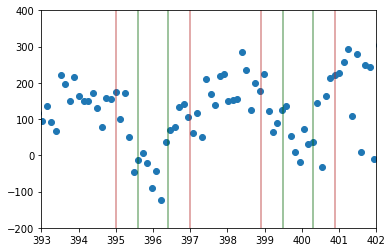

In [24]:
# Wide wavelength range

# The index at which the plotted spectrum is in the data
plotted_spectrum = 500

# Specify wavelength ranges for the K line
K_min_target = 395.6
K_max_target = 396.4
K_min_comparison = 395.0
K_max_comparison = 397.0

# Plot one of the spectra and zoom in roughly on the H&K lines
plt.plot(wlen,rflux[plotted_spectrum],'o')
plt.xlim(393,402)
plt.ylim(-200,400)

# Plot green lines to represent the target wavelength range
plt.plot([K_min_target]*2,[-5000,5000],'darkgreen',alpha=.5)
plt.plot([K_max_target]*2,[-5000,5000],'darkgreen',alpha=.5)
# Plot red lines to represent the comparison wavelength range
plt.plot([K_min_comparison]*2,[-5000,5000],'firebrick',alpha=.5)
plt.plot([K_max_comparison]*2,[-5000,5000],'firebrick',alpha=.5)


# Specify wavelength ranges for the H line
H_min_target = 399.5
H_max_target = 400.3
H_min_comparison = 398.9
H_max_comparison = 400.9

# Plot green lines to represent the target wavelength range
plt.plot([H_min_target]*2,[-5000,5000],'darkgreen',alpha=.5)
plt.plot([H_max_target]*2,[-5000,5000],'darkgreen',alpha=.5)
# Plot red lines to represent the comparison wavelength range
plt.plot([H_min_comparison]*2,[-5000,5000],'firebrick',alpha=.5)
plt.plot([H_max_comparison]*2,[-5000,5000],'firebrick',alpha=.5)

# Display the plot
plt.show()

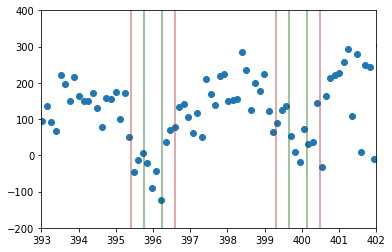

In [25]:
# Narrow wavelength range

# The index at which the plotted spectrum is in the data
plotted_spectrum = 500

# Specify wavelength ranges for the K line
K_min_target = 395.75
K_max_target = 396.25
K_min_comparison = 395.4
K_max_comparison = 396.6

# Plot one of the spectra and zoom in roughly on the H&K lines
plt.plot(wlen,rflux[plotted_spectrum],'o')
plt.xlim(393,402)
plt.ylim(-200,400)

# Plot green lines to represent the target wavelength range
plt.plot([K_min_target]*2,[-5000,5000],'darkgreen',alpha=.5)
plt.plot([K_max_target]*2,[-5000,5000],'darkgreen',alpha=.5)
# Plot red lines to represent the comparison wavelength range
plt.plot([K_min_comparison]*2,[-5000,5000],'firebrick',alpha=.5)
plt.plot([K_max_comparison]*2,[-5000,5000],'firebrick',alpha=.5)


# Specify wavelength ranges for the H line
H_min_target = 399.65
H_max_target = 400.15
H_min_comparison = 399.3
H_max_comparison = 400.5

# Plot green lines to represent the target wavelength range
plt.plot([H_min_target]*2,[-5000,5000],'darkgreen',alpha=.5)
plt.plot([H_max_target]*2,[-5000,5000],'darkgreen',alpha=.5)
# Plot red lines to represent the comparison wavelength range
plt.plot([H_min_comparison]*2,[-5000,5000],'firebrick',alpha=.5)
plt.plot([H_max_comparison]*2,[-5000,5000],'firebrick',alpha=.5)

# Display the plot
plt.show()

## Generate light curves

Once you have determined wavelength ranges, you are now able to generate light curves by averaging all of the fluxes that fall within those wavelength ranges. Below, I have developed a function that does this for you.

In [28]:
# Creates lightcurve from data
def get_lightcurve(wlen,data,ranges='wide',emission_line='K'):
    # Based on whether you choose a wide or narrow range and which emission line is used, sets variables as saved values
        # (these can be changed based upon what values are determined in previous steps)
    if ranges == 'wide':
        if emission_line == 'K':
            min_targ = 395.6
            max_targ = 396.4
            min_comp = 395
            max_comp = 397
        elif emission_line == 'H':
            min_targ = 399.5
            max_targ = 400.3
            min_comp = 398.9
            max_comp = 400.9

    elif ranges == 'narrow':
        if emission_line == 'K':
            min_targ = 395.75
            max_targ = 396.25
            min_comp = 395.4
            max_comp = 396.6

        elif emission_line == 'H':
            min_targ = 399.65
            max_targ = 400.15
            min_comp = 399.3
            max_comp = 400.5

    # Finds the indices of the columns that fall in the targed wavelength range
    target_wavelengths = np.where((wlen > min_targ)&(wlen < max_targ))[0]
    # Finds the indices of the columns that fall in the comparison wavelength range
    comparison_wavelengths = np.where(((wlen > min_comp)&(wlen < min_targ))|
                                      ((wlen > max_targ)&(wlen < max_comp)))[0]
    # Saves the indices for the full spectrum
    most_wavelengths = np.where((wlen > 380)&(wlen < 440))[0]
    # Loops through each time stamp and averages fluxes within the wavelength range, generating light curves
    target_flux = [np.mean(i) for i in data[:,target_wavelengths]]
    comparison_flux = [np.mean(i) for i in data[:,comparison_wavelengths]]
    all_flux = [np.mean(i) for i in data[:,most_wavelengths]]
    return np.array(target_flux[1:]),np.array(comparison_flux[1:]),np.array(all_flux[1:])

In [37]:
def polyreduce(time,flux,comp_flux):
    # Fit raw target light curve to polynomial
    a=np.polyfit(time,flux,10)
    b=np.poly1d(a)
    # Divide light curve by fitted polynomial
    pflux = np.subtract(flux,b(time))+2000

    # Fit raw comparison light curve to polynomial
    aa=np.polyfit(time,comp_flux,10)
    bb=np.poly1d(aa)
    # Divide light curve by fitted polynomial
    comp_pflux = np.subtract(comp_flux,bb(time))+2000

    # Plots raw light curves with fitted polynomials
    plt.plot(time,flux,'.',label='Raw Target Light Curve')
    plt.plot(time,comp_flux,'.',label="Raw Comparison Light Curve ")
    plt.plot(time,b(time),label='Fitted Target Polynomial')
    plt.plot(time,bb(time),label='Fitted Comparison Polynomial')
    plt.title('Raw Data and Fitted Polynomial')
    plt.legend()
    plt.show()

    # Plot polynomial-divided light curves
    plt.plot(time,pflux)
    plt.plot(time,comp_pflux)
    plt.title('Polynomial-divided Lightcurves')
    plt.show()

    # Plot divided light curve
    plt.plot(time,np.divide(pflux,comp_pflux))
    plt.title('Divided lightcurve after division by polynomial')
    plt.xlabel('Observation Time (UT)')
    plt.ylabel('Flux')
    plt.show()
    return np.divide(pflux,comp_pflux)

C:\Users\Melissa\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Melissa\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: RankWarning: Polyfit may be poorly conditioned
  if __name__ == '__main__':


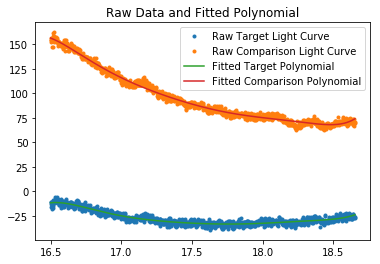

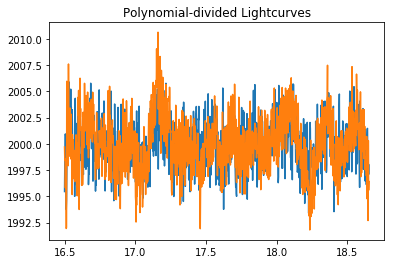

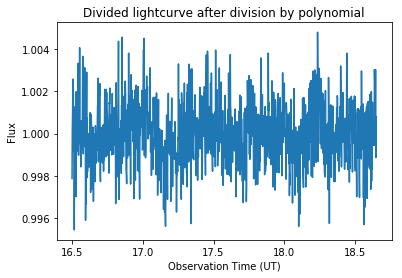

array([ 0.99787749,  1.0001185 ,  1.0011205 , ...,  0.99886782,
        1.00075483,  1.00079186])

In [38]:
flux,comp_flux,most_flux = get_lightcurve(wlen,np.array(rflux),ranges='wide',emission_line='K')
polyreduce(time,flux,comp_flux)

C:\Users\Melissa\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Melissa\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: RankWarning: Polyfit may be poorly conditioned
  if __name__ == '__main__':


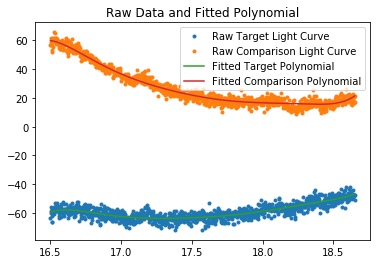

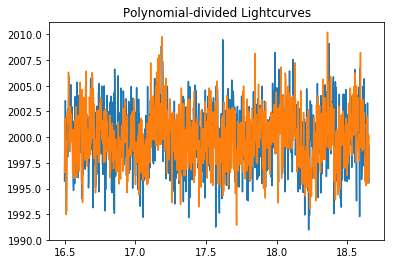

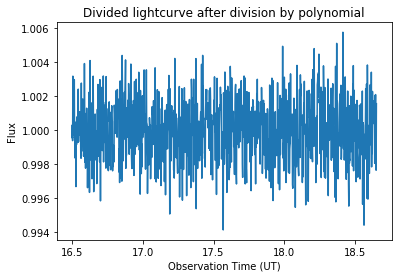

array([ 0.99957098,  1.00031497,  0.99939083, ...,  0.9999563 ,
        0.997653  ,  1.00156127])

In [39]:
flux,comp_flux,most_flux = get_lightcurve(wlen,np.array(rflux),ranges='narrow',emission_line='K')
polyreduce(time,flux,comp_flux)

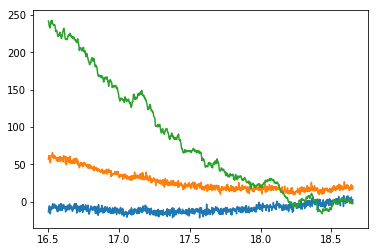

In [40]:
# A plot of the target and comparison light curves, as well as a light curve for the whole spectrum -- may be worth looking into?

plt.plot(time,flux+50)
plt.plot(time,comp_flux)
plt.plot(time,most_flux-400)
plt.show()

In [ ]:
## 